# 对比决策树算法和随机森林

> 使用[Loan Prediction](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/?utm_source=blog&utm_medium=decision-tree-vs-random-forest-algorithm#About)数据集，需要提前下载好。
>
>（为了方便读者，已将此数据集放在[文件](./dataset.csv)当中）

说明：

为了方便起见，这里只对训练集进行了切割并进行训练和预测。有兴趣读者可以自行前往[Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/?utm_source=blog&utm_medium=decision-tree-vs-random-forest-algorithm#ProblemStatement)参加这场竞赛。

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 导入数据集与预处理

### 读入数据集

In [39]:
df = pd.read_csv('./dataset.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### 数据预处理
 主要处理数据中的分类变量和填充缺失值，规则如下：
 * 对于连续变量，用平均值（对于各个列）来估算
 * 分类标签（字符串类型）进行编码

#### 填充

In [40]:
# 缺失值的列
fill_mode = ['Gender','Married','Dependents','Self_Employed','Credit_History']  # 使用众数填充列
fill_avg = ['LoanAmount','Loan_Amount_Term']  # 使用平均值填充列

values_mode = df[fill_mode].mode().to_dict('records')[0]
df[fill_mode] = df[fill_mode].fillna(value=values_mode)  # 众数填充

values_avg = df[fill_avg].mean().to_dict()
print(values_avg)
df[fill_avg] = df[fill_avg].fillna(value=values_avg)  # 平均值填充

{'LoanAmount': 146.41216216216216, 'Loan_Amount_Term': 342.0}


#### 编码

In [41]:
# 编码
le = LabelEncoder()
cols = (df.dtypes != (np.int64 and np.float64))
encode_list = cols[cols == True].index  # 需要编码的列名
for encode_col in encode_list.values:
    df[encode_col] = le.fit_transform(df[encode_col].astype(str))  # 编码

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,1,0,0,0,0,423,0.0,146.412162,360.0,1.0,2,1
1,1,1,1,1,0,0,352,1508.0,128.000000,360.0,1.0,0,0
2,2,1,1,0,0,1,180,0.0,66.000000,360.0,1.0,2,1
3,3,1,1,0,1,0,131,2358.0,120.000000,360.0,1.0,2,1
4,4,1,0,0,0,0,428,0.0,141.000000,360.0,1.0,2,1


#### 切分训练集与测试集
切分出20%的测试集

In [42]:
X = df.drop(columns=['Loan_ID', 'Loan_Status']).values
y = df['Loan_Status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)  # 为了方便调参，还是建议加上random_state参数

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((491, 11), (491,), (123, 11), (123,))

## 建立模型
> 下面决策树和随机森林的模型来训练和预测我们的数据集

#### 决策树

In [43]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

效果评估

计算F1-score的值

$F 1-\text { score }=\frac{2 * \text { Precision } * \text { Recall }}{\text { Precision }+\text { Recall }}$

In [44]:
dt_pred = dt.predict(X_test)
print('F1-Score with Decision Tree:', f1_score(y_test, dt_pred))

F1-Score with Decision Tree: 0.7730061349693251


#### 随机森林

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', random_state=42)
rf.fit(X_train, y_train)

# 评估
rf_pred = rf.predict(X_test)
print('F1-Score with Random Forest:', f1_score(y_test, rf_pred))


F1-Score with Random Forest: 0.778443113772455


#### 模型对比

In [46]:
# 观察重要属性
feature_importance=pd.DataFrame({
    'rf':rf.feature_importances_,
    'dt':dt.feature_importances_
},index=df.drop(columns=['Loan_ID','Loan_Status']).columns)
feature_importance.sort_values(by='rf',ascending=True,inplace=True)

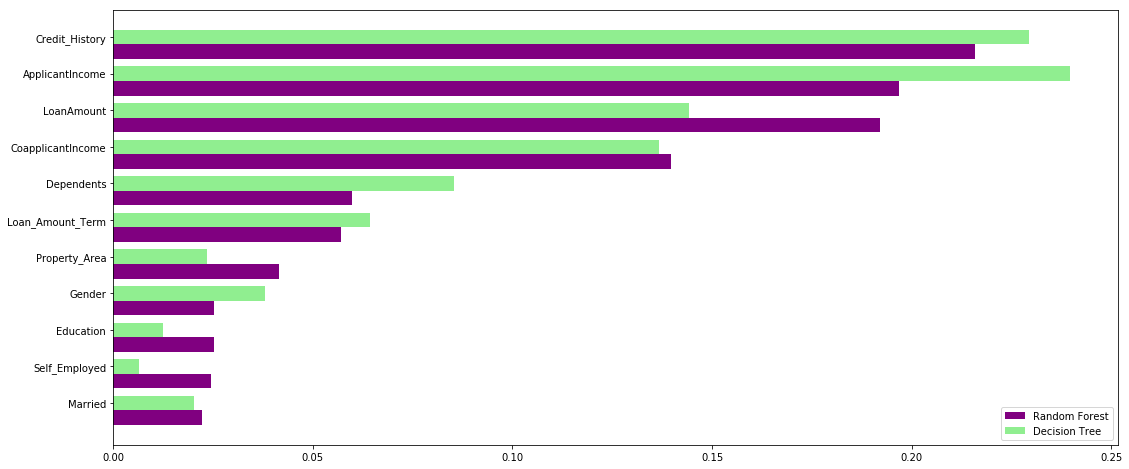

In [47]:
# 可视化结果
index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rf_feature=ax.barh(index, feature_importance['rf'], 0.4, color='purple', label='Random Forest')
dt_feature=ax.barh(index+0.4, feature_importance['dt'], 0.4, color='lightgreen', label='Decision Tree')
ax.set(yticks=index+0.4, yticklabels=feature_importance.index)

ax.legend()
plt.show()